<a href="https://colab.research.google.com/github/PashaLikhterov/Deep-Learning/blob/main/Car_color_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preperation
##Download VCOR dataset from kaggle.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
! mkdir  "/content/gdrive/MyDrive/Car color detection/dataset2"

In [ ]:
!tree -d "/content/gdrive/MyDrive/Car color detection/"

/content/gdrive/MyDrive/Car color detection/
├── dataset
│   ├── test
│   │   ├── beige
│   │   ├── black
│   │   ├── blue
│   │   ├── brown
│   │   ├── gold
│   │   ├── green
│   │   ├── grey
│   │   ├── orange
│   │   ├── pink
│   │   ├── purple
│   │   ├── red
│   │   ├── silver
│   │   ├── tan
│   │   ├── white
│   │   └── yellow
│   ├── train
│   │   ├── beige
│   │   ├── black
│   │   ├── blue
│   │   ├── brown
│   │   ├── gold
│   │   ├── green
│   │   ├── grey
│   │   ├── orange
│   │   ├── pink
│   │   ├── purple
│   │   ├── red
│   │   ├── silver
│   │   ├── tan
│   │   ├── white
│   │   └── yellow
│   └── val
│       ├── beige
│       ├── black
│       ├── blue
│       ├── brown
│       ├── gold
│       ├── green
│       ├── grey
│       ├── orange
│       ├── pink
│       ├── purple
│       ├── red
│       ├── silver
│       ├── tan
│       ├── white
│       └── yellow
└── Kaggle

50 directories


##Create custom dataset

In [ ]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device
device = set_device()

GPU is enabled in this notebook.


In [ ]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
import json
import math
from sklearn.model_selection import train_test_split

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

  def __init__(self, root):
    ds = datasets.ImageFolder(root)
    self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
            #transforms.RandomCrop(90, pad_if_needed=True)
            transforms.Resize([128,128],)
        ])
    self.samples = [sample for sample in tqdm(ds)]

  def __getitem__(self, index):
    return self.transforms(self.samples[index][0]), self.samples[index][1]
    
  def __len__(self):
    return len(self.samples)
    

In [ ]:
def create_Datasets(train_dir, val_dir, test_dir, batch_size = 16):
  '''This function given all the dataset paths, return a data object for each set.'''
  # Data loading.
  norm_mean = 0.5 
  norm_std = 0.5

  #Training Dataset
  train_Dataset = CustomDataset(train_dir)
  train_loader = torch.utils.data.DataLoader(
      train_Dataset, batch_size= batch_size*2, shuffle=True,num_workers=2)

  #Validatoin Dataset
  val_Dataset = CustomDataset(val_dir)
  val_loader = torch.utils.data.DataLoader(
      val_Dataset, batch_size=batch_size, shuffle=True, )

  #Test
  test_Dataset = CustomDataset(test_dir)
  test_loader = torch.utils.data.DataLoader(
      test_Dataset, batch_size=batch_size, shuffle=True, )
  return train_loader, val_loader, test_loader

In [ ]:
train_path = '/content/gdrive/MyDrive/Car color detection/dataset/train'
val_path = '/content/gdrive/MyDrive/Car color detection/dataset/val'
test_path = '/content/gdrive/MyDrive/Car color detection/dataset/test'

In [ ]:
train_loader, val_loader, test_loader = create_Datasets(train_dir=train_path, val_dir=val_path, test_dir = test_path)

  0%|          | 0/7267 [00:00<?, ?it/s]

  0%|          | 0/1550 [00:00<?, ?it/s]

  0%|          | 0/1556 [00:00<?, ?it/s]

In [ ]:
for data, target in train_loader:
  print(target)
  break

tensor([14,  8,  8, 14, 10,  6,  3, 14, 10,  2,  3,  2,  8,  2,  7, 13,  5, 14,
         2,  5,  5,  0,  8,  7, 10,  3, 12, 12, 12,  6,  2,  8])


In [ ]:
data[0].shape

torch.Size([3, 90, 90])

##Creating model

In [ ]:
class CNN1_Part1(nn.Module):
    def __init__(self, input_size=3, n_feature=8, kernel_size=3):
        super(CNN1_Part1, self).__init__()
        self.n_feature = n_feature
        
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=n_feature, kernel_size=kernel_size)
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=2*n_feature, kernel_size=kernel_size)
        self.conv3 = nn.Conv2d(in_channels=2*n_feature, out_channels=4*n_feature, kernel_size=kernel_size)
        self.conv4 = nn.Conv2d(in_channels=4*n_feature, out_channels=8*n_feature, kernel_size=kernel_size)
        self.conv5 = nn.Conv2d(in_channels=8*n_feature, out_channels=16*n_feature, kernel_size=kernel_size)

        self.batchnorm1 = nn.BatchNorm2d(num_features=n_feature)
        self.batchnorm2 = nn.BatchNorm2d(num_features=2*n_feature)
        self.batchnorm3 = nn.BatchNorm2d(num_features=4*n_feature)
        self.batchnorm4 = nn.BatchNorm2d(num_features=8*n_feature)
        self.batchnorm5 = nn.BatchNorm2d(num_features=16*n_feature)


        self.dropout = nn.Dropout(p=0.2, inplace=False)

        #For 3 layers use this lines of code
        # self.fc1 = nn.Linear(in_features=32*25*40, out_features=128)
        # self.fc2 = nn.Linear(in_features=128, out_features=10)

        #For 5 layers use this line of code
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=100)
        self.fc2  = nn.Linear(in_features=100, out_features=15)
        
    def forward(self, x, verbose=False):

        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # x = self.dropout(x)
        

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # x = self.dropout(x)
        
        # Conv layer 4.
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 5.
        # x = self.conv5(x)
        # x = self.batchnorm5(x)
        # x = self.dropout(x)
        # x = F.relu(x)
        # x = F.max_pool2d(x, kernel_size=2)

        # Fully connected layer 1.
        # print(x.shape)
        x = torch.flatten(x, 1)

        # For dropout uncomment this row
        # x = self.dropout(x)

        x = self.fc1(x)

        # If needed
        x = self.fc2(x)


        x = F.softmax(x)

        return x

In [ ]:
class CNN2_Part1(nn.Module):
    def __init__(self, input_size=3, n_feature=8, kernel_size=3):
        super(CNN2_Part1, self).__init__()
        self.n_feature = n_feature
        
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=n_feature, kernel_size=kernel_size)
        self.conv1_1 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=kernel_size, padding='same')
        self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=2*n_feature, kernel_size=kernel_size)
        self.conv2_2 = nn.Conv2d(in_channels=2*n_feature, out_channels=2*n_feature, kernel_size=kernel_size, padding='same')
        self.conv3 = nn.Conv2d(in_channels=2*n_feature, out_channels=4*n_feature, kernel_size=kernel_size)
        self.conv3_3 = nn.Conv2d(in_channels=4*n_feature, out_channels=4*n_feature, kernel_size=kernel_size, padding='same')
        self.conv4 = nn.Conv2d(in_channels=4*n_feature, out_channels=8*n_feature, kernel_size=kernel_size)
        self.conv5 = nn.Conv2d(in_channels=8*n_feature, out_channels=16*n_feature, kernel_size=kernel_size)

        self.batchnorm1 = nn.BatchNorm2d(num_features=n_feature)
        self.batchnorm2 = nn.BatchNorm2d(num_features=2*n_feature)
        self.batchnorm3 = nn.BatchNorm2d(num_features=4*n_feature)
        self.batchnorm4 = nn.BatchNorm2d(num_features=8*n_feature)
        self.batchnorm5 = nn.BatchNorm2d(num_features=16*n_feature)


        self.dropout = nn.Dropout(p=0.2, inplace=False)

        #For 3 layers use this lines of code
        # self.fc1 = nn.Linear(in_features=32*25*40, out_features=128)
        # self.fc2 = nn.Linear(in_features=128, out_features=10)

        #For 5 layers use this line of code
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=15)
        self.fc2  = nn.Linear(in_features=100, out_features=15)
        
    def forward(self, x, verbose=False):

        # Conv layer 1.
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = F.relu(x)
        x = self.conv1_1(x)
        x = F.relu(x)

        # Conv layer 2.
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2_2(x)
        x = F.relu(x)
        x = self.dropout(x)
        

        # Conv layer 3.
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3_3(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Conv layer 4.
        x = self.conv4(x)
        x = self.batchnorm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        # Conv layer 5.
        # x = self.conv5(x)
        # x = self.batchnorm5(x)
        # x = self.dropout(x)
        # x = F.relu(x)
        # x = F.max_pool2d(x, kernel_size=2)

        # Fully connected layer 1.
        # print(x.shape)
        x = torch.flatten(x, 1)

        # For dropout uncomment this row
        # x = self.dropout(x)

        x = self.fc1(x)

        # If needed
        # x = self.fc2(x)


        x = F.softmax(x)

        return x

##Training function

In [ ]:
def train(model, device, train_loader, validation_loader,
          epochs ,lr ,weight_decay=None, flag_rnn=False, batch_size =16):
  '''Model training function for each model'''
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lr ,weight_decay=weight_decay)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
      tepochs.set_description('Training')
      for epoch in tepochs:
        model.train()
        # keep track of the running loss
        running_loss = 0.
        correct, total = 0, 0

        for data, target in train_loader:
          # getting the training set

          #******For section 3.2 *****
          # input1 = data[0]
          # input2 = data[1]
          # input1,input2, target = input1.to(device), input2.to(device), target.to(device)
          # output = model((input1,input2))
          
          #******For the rest of the project ******
          data, target = data.to(device), target.to(device)
          # Get the model output (call the model with the data from this batch)
          output = model(data)
          # Zero the gradients out)
          optimizer.zero_grad()
          # Get the Loss
          loss  = criterion(output, target)
          # Calculate the gradients
          loss.backward()
          # Update the weights (using the training step of the optimizer)
          optimizer.step()

          tepochs.set_postfix(loss=loss.item())
          running_loss += loss.item()  # add the loss for this batch

          # get accuracy
          _, predicted = torch.max(output, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

        # append the loss for this epoch
        train_loss.append(running_loss/len(train_loader))
        train_acc.append(correct/total)

        # evaluate on validation data
        model.eval()
        running_loss = 0.
        correct, total = 0, 0

        for data, target in validation_loader:
          # getting the validation set
          #******For section 3.2 *****
          # input1 = data[0]
          # input2 = data[1]
          # input1,input2, target = input1.to(device), input2.to(device), target.to(device)

          
          #******For the rest of the project ******
          data, target = data.to(device), target.to(device)
          # Get the model output (call the model with the data from this batch)
          optimizer.zero_grad()
          output = model(data)
          # output = model((input1,input2))
          loss = criterion(output, target)
          tepochs.set_postfix(loss=loss.item())
          running_loss += loss.item()
          # get accuracy
          _, predicted = torch.max(output, 1)
          total += target.size(0)
          correct += (predicted == target).sum().item()

        validation_loss.append(running_loss/len(validation_loader))
        validation_acc.append(correct/total)
  return train_loss, train_acc, validation_loss, validation_acc

##Plot Training Loss

In [ ]:
#  Plotting function.
def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  '''For given output vectors, plot the corresponding graphs.'''
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

  0%|          | 0/25 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


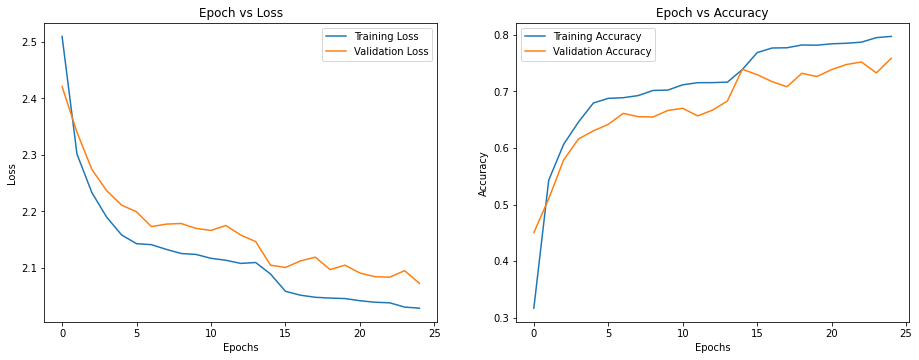

In [ ]:
#without dropout
model = CNN1_Part1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model, device, train_loader, val_loader,
                                                               epochs=25, lr = 0.0001, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

  0%|          | 0/40 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


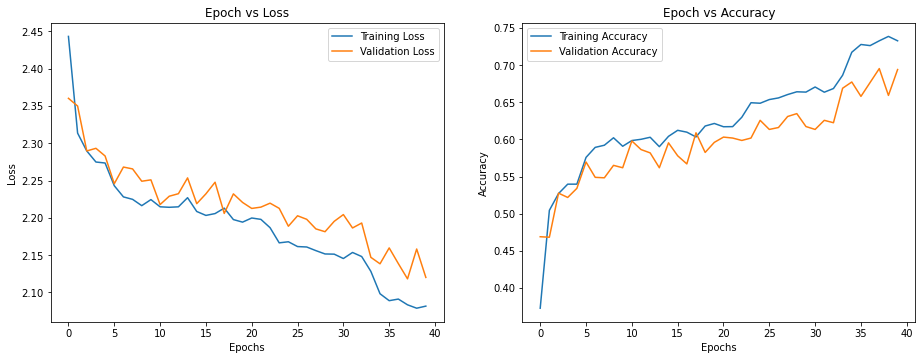

In [ ]:
#without dropout
model2 = CNN1_Part1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model2, device, train_loader, val_loader,
                                                               epochs=40, lr = 0.0005, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


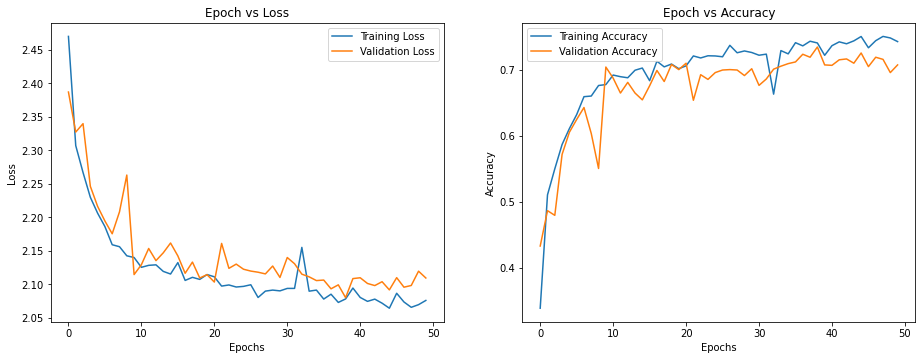

In [ ]:
#with fc2
model3 = CNN2_Part1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model3, device, train_loader, val_loader,
                                                               epochs=50, lr = 0.0005, weight_decay=0)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

  0%|          | 0/50 [00:00<?, ?epoch/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


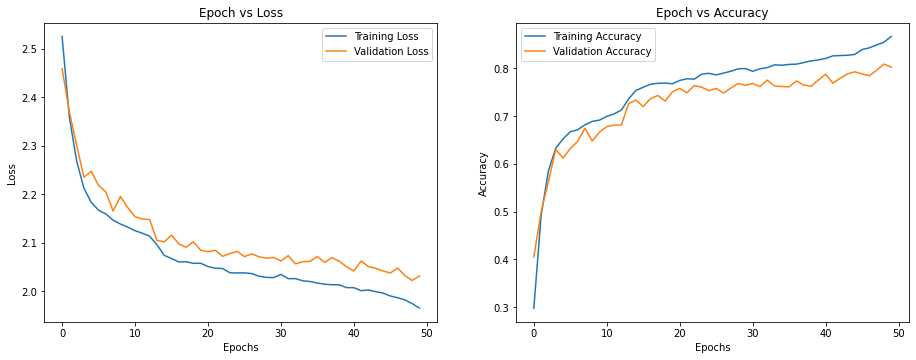

In [ ]:
#without fc2
model3 = CNN2_Part1().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(model3, device, train_loader, val_loader,
                                                               epochs=50, lr = 0.0001, weight_decay=1e-5)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

## Testing function

In [ ]:
def test(model, test_loader):
  '''Test current model for given dataset'''
  criterion =  nn.CrossEntropyLoss()
  test_loss = 0
  correct = 0
  accuracy_list = []
  running_loss = 0.
  correct, total = 0, 0
  model.eval()
  for data, target in tqdm(test_loader):
    # getting the validation set
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    running_loss += loss.item()
    # get accuracy
    _, predicted = torch.max(output, 1)
    total += target.size(0)
    correct += (predicted == target).sum().item()

  test_loss=(running_loss/len(test_loader))
  accuracy = 100. * correct / len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      accuracy))

In [ ]:
test(model, test_loader)

  0%|          | 0/98 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 2.0305, Accuracy: 1229/1556 (79%)



In [ ]:
test(model3, test_loader)

  0%|          | 0/98 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 2.0412, Accuracy: 1246/1556 (80%)

